# Multiple neural network layers with `Flux.jl`

In a previous notebook, we saw that one layer of neurons wasn't enough to distinguish between three types of fruit (apples, bananas *and* grapes), since the data is quite complex. To solve this problem, we need to use more layers, so heading into the territory of **deep learning**!

By adding another layer between the inputs and the output neurons, a so-called "hidden layer", we will get our first serious **neural network**, looking something like this:

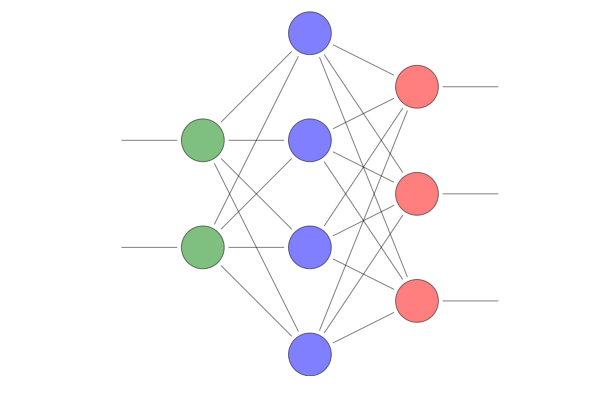

In [1]:
include("draw_neural_net.jl")
draw_network([2, 4, 3])

We will continue to use two input data and try to classify into three types, so we will have three output neurons. We have chosen to add a single "hidden layer" in between, and have arbitrarily chosen to put 4 neurons there.

Much of the *art* of deep learning is choosing a suitable structure for the neural network that will allow the model to be sufficiently complex to model the data well, but sufficiently simple to allow the parameters to be learned in a reasonable length of time.

## Read in and process data

As before, let's load some pre-processed data using code we've seen in the previous notebook.

In [2]:
using Flux
using Flux: onehot

In [4]:
using CSV

apples_1 = CSV.read("data/Apple_Golden_1.dat", delim='\t')
apples_2 = CSV.read("data/Apple_Golden_2.dat", delim='\t')
apples_3 = CSV.read("data/Apple_Golden_3.dat", delim='\t')
bananas = CSV.read("data/Banana.dat", delim='\t')
grapes_1 = CSV.read("data/Grape_White.dat", delim='\t')
grapes_2 = CSV.read("data/Grape_White_2.dat", delim='\t');

apples = vcat(apples_1, apples_2, apples_3)
grapes = vcat(grapes_1, grapes_2);

INFO: Recompiling stale cache file /Users/alanedelman/.julia/lib/v0.6/CSV.ji for module CSV.


In [5]:
col1 = :red
col2 = :blue

x_apples  = [ [apples_1[i, col1], apples_1[i, col2]] for i in 1:size(apples_1)[1] ]
append!(x_apples, [ [apples_2[i, col1], apples_2[i, col2]] for i in 1:size(apples_2)[1] ])
append!(x_apples, [ [apples_3[i, col1], apples_3[i, col2]] for i in 1:size(apples_3)[1] ])

x_bananas = [ [bananas[i, col1], bananas[i, col2]] for i in 1:size(bananas)[1] ]

x_grapes = [ [grapes_1[i, col1], grapes_1[i, col2]] for i in 1:size(grapes_1)[1] ]
append!(x_grapes, [ [grapes_2[i, col1], grapes_2[i, col2]] for i in 1:size(grapes_2)[1] ])

xs = vcat(x_apples, x_bananas, x_grapes);

We now we wish to classify the three types of fruit, so we again use one-hot vectors to represent the desired outputs $y^{(i)}$:

In [6]:
labels = [ones(length(x_apples)); 2*ones(length(x_bananas)); 3*ones(length(x_grapes))];

ys = [onehot(label, 1:3) for label in labels];  # onehotbatch(labels, 1:3)

The input data is in `xs` and the one-hot vectors are in `ys`.

## Multiple layers in Flux

Let's tell Flux what structure we want the network to have. We first specify the number of neurons in each layer, and then construct each layer as a `Dense` layer:

In [7]:
inputs = 2
hidden = 4
outputs = 3

layer1 = Dense(inputs, hidden, σ)
layer2 = Dense(hidden, outputs, σ)

Dense(4, 3, NNlib.σ)

To stitch together multiple layers to make a multi-layer network, we use Flux's `Chain` function:

In [8]:
model = Chain(layer1, layer2)

Chain(Dense(2, 4, NNlib.σ), Dense(4, 3, NNlib.σ))

#### Exercise 1

What is the internal structure and sub-structure of this `model` object?

#### Solution

In [ ]:
model.layers

So `model` understands that it consists of two layers, and:

In [ ]:
model.layers[1].W

In [ ]:
model.layers[1].b

So both the layers have their own `W` and `b`, just as you might expect -- `Flux` wraps all this up in a way that is structured but easy to use.  

In particular, using `params` returns *all* the parameters hidden inside the `model` object, that is the pairs $(W, b)$ from both layers:

In [ ]:
params(model)

## Training the model

We have now set up a model and we have some training data.
How do we train the model on the data?
    
The amazing thing is that the rest of the code in `Flux` is **exactly the same as before**. This is possible thanks to the design of Julia itself, and of the `Flux` package.

#### Exercise 2

Train the model as before, now using the popular `ADAM` optimizer. You may need to train the network for longer than before, since we have many more parameters.

#### Solution

In [ ]:
loss(x, y) = Flux.mse(model(x), y)

In [ ]:
data = zip(xs, ys);

In [ ]:
opt = ADAM(params(model), 0.02)

In [ ]:
for i in 1:1000
    Flux.train!(loss, data, opt)
end

Let's check the final values of the parameters:

In [ ]:
params(model)

## Visualizing the results

What does this neural network represent? It is simply a more complicated function with two inputs and three outputs, i.e. a function $f: \mathbb{R}^2 \to \mathbb{R}^3$. 
Before, with a single layer, each component of the function $f$ basically corresponded to a hyperplane; now it will instead be a **more complicated nonlinear function** of the input data!

#### Exercise 3

Visualize each component of the output separately as a heatmap and/or contours superimposed on the data. Interpret the results.

#### Solution

In [ ]:
coords = 0:0.01:0.8

heatmap(coords, coords, (x,y)->model([x,y]).data[1])
#contour!(coords, coords, (x,y)->model([x,y]).data[1], levels=[0.5, 0.501], lw=3)

scatter!(first.(x_apples), last.(x_apples), m=:cross, label="apples")
scatter!(first.(x_bananas), last.(x_bananas), m=:circle, label="bananas")
scatter!(first.(x_grapes), last.(x_grapes), m=:square, label="grapes")

xlims!(0.4, 0.8)
ylims!(0.1, 0.5)

We see that the first component, which is supposed to separate apples from non-apples, has been able to learn a set that has a much more complicated shape than simply a hyperplane: the hyperplane has been bent round. Sometimes it's able to encapsulate all the apple data, while sometimes it isn't, depending on how well it learnt.

In [ ]:
coords = 0:0.01:1

#contour(coords, coords, (x,y)->model([x,y]).data[2], levels=[0.5, 0.501], lw=3)
heatmap(coords, coords, (x,y)->model([x,y]).data[2])

scatter!(first.(x_apples), last.(x_apples), m=:cross, label="apples")
scatter!(first.(x_bananas), last.(x_bananas), m=:circle, label="bananas")
scatter!(first.(x_grapes), last.(x_grapes), m=:square, label="grapes")

xlims!(0.4, 0.8)
ylims!(0.1, 0.5)

The second component is very successful at separating out the bananas. Since there are some apples mixed in there, it can't be expected to do too much better.

In [ ]:
coords = 0:0.01:1

heatmap(coords, coords, (x,y)->model([x,y]).data[3])
contour!(coords, coords, (x,y)->model([x,y]).data[3], levels=[0.5, 0.501], lw=3)


scatter!(first.(x_apples), last.(x_apples), m=:cross, label="apples")
scatter!(first.(x_bananas), last.(x_bananas), m=:circle, label="bananas")
scatter!(first.(x_grapes), last.(x_grapes), m=:square, label="grapes")

xlims!(0.4, 0.8)
ylims!(0.1, 0.5)

The third component separates grapes from the rest pretty successfully.

## What we have learned

Adding an intermediate layer allows the network to start to deform the separating surfaces that it is learning into more complicated, nonlinear (curved) shapes. This allows it to separate data that were previously unable to be separated!

However, using only two features means that data from different classes overlaps. To distinguish it we would need to use more features.

### Exercise 4

Use three features (red, green and blue) and build a network with one hidden layer. Does this help to distinguish the data better?